### Estimating thermodynamic sea-ice growth during the breakup event 

**For the WRF10 experiment**

#### Author: Jonathan Rheinlænder*
#### Date: Aug. 27 2021
#### Affiliation: Nansen Environmental and Remote Sensing Center, Bergen, Norway
*jonathan.rheinlaender@nersc.no

In [ ]:
%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
import struct
import xarray as xr
from datetime import datetime
import matplotlib as mpl
import sys
import os
import datetime as dt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid.inset_locator import inset_axes
from cartopy.mpl.geoaxes import GeoAxes

from pynextsim.projection_info import ProjectionInfo

import matplotlib.dates as mdates
import pandas as pd
import cmocean as cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from shapely.geometry.polygon import Polygon
import matplotlib.patches as mpatches

from calc_IceGrowth_2013breakup import IceGrowth


In [7]:
def make_figure(wi, hi, nrow,ncol):

    fig = plt.figure(figsize=(wi,hi))
    #plt.subplots_adjust(hspace=5, wspace=0.01, top=0.95, bottom=0.1, left=0.075, right=0.925)
    gs = gridspec.GridSpec(nrow,ncol)
    
    return fig, gs 

In [8]:
# load data

rootdir = '/home/rheinlender/shared-simstore-ns9829k/'
inpath = rootdir + 'home/rheinlender/data/nextsim-output/breakup2013/start_20130213_nudging/'
outpath_plots =  rootdir + 'home/rheinlender/figs/breakup-paper/'

expts = ["expt_01_wrf10/outputs/", "expt_01_wrf10-nodyn/outputs/"]
expts_names = ["wrf10",'no_motion']

files = [os.path.join(inpath, f, 'Moorings.nc') for f in expts]
ds0 = xr.open_dataset(files[0])
ds1 = xr.open_dataset(files[1])
dslist = [ds0, ds1]

# subset region: Beaufort Sea
x0=0; x1=260; y0=150; y1=410
bbox =  (x0, x1, y0, y1)
cell_area = 5000*5000 # 5km spacing 

days = mdates.DayLocator()  # every day
dtFmt = mdates.DateFormatter('%b%d') # define the formatting 

# Average volume growth in the Beaufort Sea for different ice types

Applying bbox (0, 260, 150, 410)


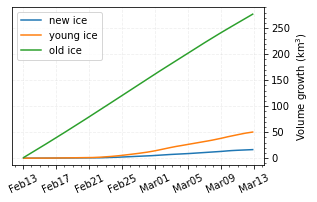

saving... /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/figs/breakup-paper/volume_growth_beaufort_wrf10.png


In [41]:
time = ds0['time'].time.values.astype('datetime64[ms]').astype('O')

Igrowth = IceGrowth(ds0.copy(), bbox)

# fix timestep
Igrowth.fix_growthrate()
    
# calculate ice volume growth
dVol = Igrowth.calc_vol_growth(cell_area)
    
# total ice volume growth (cumulative sum)
dVol['newice_tot']  = dVol['newice'].cumsum(axis=0)*1e-9 # in km3
dVol['youngice_tot'] = dVol['del_vi_thin'].cumsum(axis=0)*1e-9 
dVol['oldice_tot'] = dVol['del_vi'].cumsum(axis=0)*1e-9  
    
plt.close('all')
fig, ax = plt.subplots(1,1, figsize=(3.5,2.5))
l1 = ax.plot(time, dVol['newice_tot'], label='new ice')
l2 = ax.plot(time, dVol['youngice_tot'], label='young ice')
l3 = ax.plot(time, dVol['oldice_tot'], label='old ice')

ax.set_ylabel('Volume growth ($\mathrm{km^3}$)')
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())

#ax.label_outer()
ax.grid(linestyle='--', alpha=0.2)
ax.xaxis.set_major_formatter(dtFmt)
ax.xaxis.set_minor_locator(days)
plt.xticks(rotation=25) # rotate xlabels
plt.legend()

fig.subplots_adjust(bottom=0.1, top=0.98, left=0., right=1, wspace=0.01, hspace=0.01)
plt.show()

# save figure
figname = os.path.join(outpath_plots,
      '%s%s_%s%s' % (outpath_plots, 'volume_growth_beaufort',expts_names[0], '.png'))
print("saving...", figname)
fig.savefig(figname, dpi=300, bbox_inches='tight')


# Plot ice growth versus change in ice volume (relative to start of simulation)

Applying bbox (0, 260, 150, 410)
Applying bbox (0, 260, 150, 410)


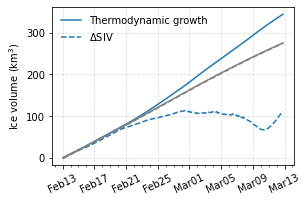

saving... /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/figs/breakup-paper/dVol+dSIV_beaufort_wrf10_no-motion.png


In [10]:
fig, ax = plt.subplots(1,1, figsize=(3.5,2.5))
expts_names = ('wrf10', 'no_motion')
labelstr = ['Thermodynamic growth', r'$\Delta$SIV']
colors = 'tab:blue', 'grey'
for i, ds in enumerate(dslist):
        
    o = IceGrowth(ds.copy(), bbox)
    
    ds_sel = o.dataset
    sivBS = ds_sel['sit']*cell_area # in m3
    sivBS_total = sivBS.sum(dim=("x", "y"))*1e-9     
    sivBS_rel = sivBS_total - sivBS_total[0] # change relative to start of simul
    
    time = ds_sel['time'].time.values.astype('datetime64[ms]').astype('O')
    
    # fix timestep
    o.fix_growthrate()
    
    # calculate ice volume growth
    dVol = o.calc_vol_growth(cell_area)
    
    # total ice volume growth (cumulative sum)
    dVol['newice_tot']  = dVol['newice'].cumsum(axis=0)*1e-9 # in km3
    dVol['youngice_tot'] = dVol['del_vi_thin'].cumsum(axis=0)*1e-9 
    dVol['oldice_tot'] = dVol['del_vi'].cumsum(axis=0)*1e-9  
    
    # Calculate the total change in volume in leads and pack-ice combined
    dVol_total = dVol['newice_tot'] + dVol['youngice_tot'] + dVol['oldice_tot']

    l1=ax.plot(time, dVol_total, ls='-', color=colors[i]) # thermodyn. growth   
    l2=ax.plot(time, sivBS_rel, ls = '--', color=colors[i])
    
plt.legend(labelstr, frameon=False)    
ax.set_ylabel(r'Ice volume (km$^3$)')  
ax.xaxis.set_major_formatter(dtFmt)
ax.xaxis.set_minor_locator(days)
ax.grid(linestyle='--', alpha=0.4)
plt.xticks(rotation=25) # rotate xlabels

fig.subplots_adjust(bottom=0.1, top=0.98, left=0., right=0.96, wspace=0.01, hspace=0.01)
plt.show()

# save figure
figname = os.path.join(outpath_plots,
      '%s%s_%s%s' % (outpath_plots, 'dVol+dSIV_beaufort','wrf10_no-motion', '.png'))
print("saving...", figname)
fig.savefig(figname, dpi=300, bbox_inches='tight')


# Average thickness growth in the Beaufort Sea

The average increase in thickness due to thermodynamic growth in the Beaufort Sea is estimated by dividing the total volume growth by the total area of the Beaufort Sea.  

Total area in Beaufort Sea: 1344575.0 km2
Average thickness growth in the Beaufort Sea: 0.25568113999960257  m


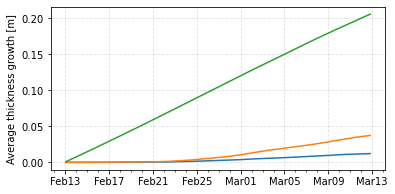

In [48]:
ds = Igrowth.dataset

mask_ocean = 1 * np.ones((ds.dims['y'], ds.dims['x'])) * np.isfinite(ds.sic.isel(time=0))  
mask_land = np.zeros((ds.dims['y'], ds.dims['x'])) * np.isnan(ds.sic.isel(time=0))  
mask_array = mask_ocean + mask_land

# total area in Beaufort Sea
tot_area = np.count_nonzero(mask_array) * cell_area # only account for ocean cells
print("Total area in Beaufort Sea:", tot_area*1e-6, "km2")



delH_newice = dVol['newice'] / tot_area
delH_youngice = dVol['del_vi_thin'] / tot_area
delH_oldice = dVol['del_vi'] / tot_area

delH_tot = delH_newice+delH_youngice+delH_oldice
            

fig, ax = plt.subplots(1,1, figsize=(6,3))
l1 = ax.plot(time, delH_newice.cumsum(axis=0))
l2 = ax.plot(time, delH_youngice.cumsum(axis=0))
l3 = ax.plot(time, delH_oldice.cumsum(axis=0))
ax.set_ylabel('Average thickness growth [m]')
ax.xaxis.set_major_formatter(dtFmt)
ax.xaxis.set_minor_locator(days)
ax.grid(linestyle='--', alpha=0.4)

print("Average thickness growth in the Beaufort Sea:", delH_tot.cumsum(axis=0)[-1].values, " m")

In [ ]:
# calculate the total weighted growth rate in leads and pack ice

def thickness_growthrate_weighted(fraction_mask, var, mask):
    
    # apply mask for Beaufort Sea
    masked_var = var.where(mask==1)
    
    delV = masked_var*cella # Volume growth (in m3/3hrs)
    
    # total volume growth in Beaufort Sea
    delVsum = delV.sum(dim=("x", "y"), skipna=True) # m3/3hrs 
    
    area_mask = fraction_mask*cella
    
    # total area which is open-water, young ice and old ice, respectively 
    area_mask_sum = area_mask.where(mask==1).sum(dim=('x', 'y'))   
    
    # average growth in meters weighted by the newice-, youngice- and oldice area
    delH_weighted = delVsum/area_mask_sum
        
    return delH_weighted

# fraction of openwater and thin ice 
leadfraction = 1 - ds['sic'] + ds['sic_thin']

# get the fraction of pack ice (1 - leadfraction)
packfraction = 1 - leadfraction 

delH_newice_wt  = thickness_growthrate_weighted((1 - ds['sic']), newice, mask) 
delH_youngice_wt = thickness_growthrate_weighted(ds['sic_thin'], del_hi_thin, mask) 
delH_oldice_wt = thickness_growthrate_weighted(packfraction, del_hi, mask)     
     
fig, ax = plt.subplots(2,1, figsize=(5,4))
ax[0].plot(time, delH_newice_wt.cumsum(axis=0),  label='new ice')
ax[0].plot(time, delH_youngice_wt.cumsum(axis=0),label='young ice')
ax[0].plot(time, delH_oldice_wt.cumsum(axis=0) , label='old ice')
ax[0].set_ylabel('Total ice growth [m]')

ax[1].plot(time, delH_newice_wt*1e2,  label='new ice')  # in cm/3hr
ax[1].plot(time, delH_youngice_wt*1e2, label='young ice')
ax[1].plot(time, delH_oldice_wt*1e2, label='old ice')
ax[1].set_ylabel(r'Growth rate [cm $\mathrm{3hr^{-1}}$]')

ax[0].legend()

for axs in ax:
    axs.label_outer()
    axs.grid(linestyle='--', alpha=0.4)
    axs.xaxis.set_major_formatter(dtFmt)
    axs.xaxis.set_minor_locator(days)

# save figure
outpath_plots = '/cluster/home/rheinlender/projects/aoi_case_study/python/breakup-paper/figs/'
figname = os.path.join(outpath_plots,
      '%s%s_%s%s' % (outpath_plots, 'thickness_growth_wt_beaufort',expts_names[k], '.png'))
print("saving...", figname)
fig.savefig(figname, dpi=300, bbox_inches='tight')
    
# Create dataframe with the average growth in open-water, youngice and oldice
df = pd.DataFrame(columns=['Expt', 
                           'Growth in open-water (m)', 
                           'Growth in young-ice (m)', 
                           'Growth in old-ice (m)'])

data0 = delH_newice_wt.cumsum(axis=0)[-1]
data1 = delH_youngice_wt.cumsum(axis=0)[-1]
data2 = delH_oldice_wt.cumsum(axis=0)[-1]

# APPEND TO DATAFRAME
df.loc[k] = [expts_names[k], 
             data0.round(decimals=1).values, 
             data1.round(decimals=1).values, 
             data2.round(decimals=1).values, 
                 ]
df


# Map of the Beaufort Sea ice thickness

In [49]:
class inset_BeaufortBox:
    
    def __init__(self, ds, ax):
        
        '''
        Parameters:
            ds: Xarray dataset 
            ax: axes handle(GeoAxes)
        '''
        
        self.ds = ds
        self.axes = ax    
        
        # Projection stuff
        self.extent = [-110, 200, 67, 90]
        self.proj = ProjectionInfo() # default nextsim projection
       
    def prepare_grid(self):

        # Get x-y grid from model
        lons = self.ds.longitude[:]
        lats = self.ds.latitude[:]
        x,y = self.proj.pyproj(lons.values, lats.values) # init grid using x,y coords of grid
        x_extent = [(x,y)[0][0][0], (x,y)[0][0][-1]]
        y_extent = [(x,y)[1][0][0], (x,y)[1][-1][0]]
        ex_lim=1
        x_extent = [(x,y)[0][0][ex_lim], (x,y)[0][0][-ex_lim]]
        y_extent = [(x,y)[1][ex_lim][0], (x,y)[1][-ex_lim][0]]

        grid = dict(
            x_extent=x_extent,
            y_extent=y_extent,
            )

        return grid

    def plot_map(self, varname, dto, clevs, cmap, add_colorbar=True, bbox=False, **cbargs):
        
        grid = self.prepare_grid()
        
        arr = self.ds[varname].sel(time=dto).mean(axis=0)
        
        cs = self.axes.contourf(arr, zorder=1, extent=[*grid['x_extent'], *grid['y_extent']],
                 levels=clevs, cmap=cmap, **cbargs)

        # add contour lines
        cl = self.axes.contour(arr, extent=[*grid['x_extent'], *grid['y_extent']], levels=clevs,  
                                       colors='k', linestyles='-',linewidths=0.3)

        self.axes.add_feature(cartopy.feature.LAND,zorder=1,alpha=1, color="darkgrey")
        self.axes.coastlines(resolution='50m', linewidth=0.5)
        self.axes.set_aspect(1)
        self.axes.gridlines(zorder=2,linewidth=0.5, alpha=0.5,linestyle="--")
        self.axes.set_extent([-100, -50, 67, 87], ccrs.PlateCarree(central_longitude=300))

        # add colorbar 
        if add_colorbar:
            cax = inset_axes(self.axes,
                        width="5%",  # width = 50% of parent_bbox width
                        height="100%",  # height : 5%
                        loc='lower left',
                        bbox_to_anchor=(1.05, 0., 1, 1),
                        bbox_transform=ax.transAxes,
                        borderpad=0)

            out = plt.colorbar(cs, cax=cax, **cbargs)

        # draw Beaufort box
        if bbox:
            self.add_box(bbox)
            
        # add text
        kw = dict(verticalalignment='bottom', horizontalalignment='center', 
                          transform=self.axes.transAxes, color='k', fontsize=9, zorder=10,
                          bbox={'facecolor':'None', 'edgecolor':'None', 'alpha':0.7, 'pad':0})
        self.axes.text(0.58, 0.5, '>1.6',**kw)
        self.axes.text(0.25, 0.4, '1$-$1.6 ',**kw)
        self.axes.text(0.33, 0.8, '<1',**kw)
            
    def add_box(self, bbox):
        '''Adds a box in axes coordinates outlining the Beaufort Sea
        '''
        
        x0, x1, y0, y1 = bbox
        
        # make Beaufort Box
        nlon = self.ds.longitude.values
        nlat = self.ds.latitude.values
        lon_corners = (nlon[y1,x0], nlon[y0,x0], nlon[y0,x1],  nlon[y1,x1]) 
        lat_corners = (nlat[y1,x0], nlat[y0,x0], nlat[y0,x1], nlat[y1,x1]) 

        poly_corners = np.zeros((len(lat_corners), 2), np.float64)
        poly_corners[:,0] = lon_corners
        poly_corners[:,1] = lat_corners

        kw = {'ec':'k', 'ls':'-', 'fill':'True', 'lw':1, 'zorder':10,'facecolor': 'white', 'alpha':0.3}
        poly = mpatches.Polygon(poly_corners, closed=True, transform=ccrs.Geodetic(), **kw)

        self.axes.add_patch(poly)  

# Histograms of sea-ice thickness before and after breakup 

mean thickness on 2013-02-16 : 1.3963089
mean thickness on 2013-03-12 : 1.4502151
median thickness on 2013-02-16 : 1.2906121
median thickness on 2013-03-12 : 1.4485677


/opt/conda/envs/pynextsim/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1586: UserWarning: The following kwargs were not used by contour: 'label'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


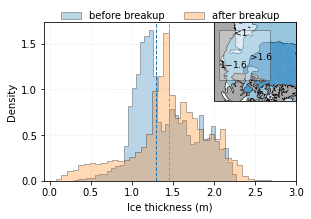

saving... /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/figs/breakup-paper/histSIT_beaufort_wrf10.png


In [52]:
plt.close('all')

# nextsim grid

# calculate thickness in Beaufort Sea 
sitBS = ds0['sit'].sel(x=slice(x0,x1), y=slice(y0,y1))

# pick dates to plot
t1 = '2013-02-16' # start of simulation
t2 = '2013-03-12' # end of simulation

print("mean thickness on", t1, ":", sitBS.sel(time=t1).mean().values)
print("mean thickness on", t2, ":", sitBS.sel(time=t2).mean().values)
print("median thickness on", t1, ":", sitBS.sel(time=t1).median().values)
print("median thickness on", t2, ":", sitBS.sel(time=t2).median().values)

legstr = ['before breakup', 'after breakup']

kwargs = dict(histtype='stepfilled', alpha=0.3, density=True, bins=40, ec="k")

fig, ax = plt.subplots(1,1, figsize=(3.5,2.5)) #old
#fig, ax = plt.subplots(1,1, figsize=(5.5,5.5))
hist1 = sitBS.sel(time=t1).plot.hist(ax=ax, **kwargs) # before break-up
hist2 = sitBS.sel(time=t2).plot.hist(ax=ax, **kwargs) # after break-up
ax.set_ylabel('Density')
ax.set_xlabel('Ice thickness (m)')
ax.set_title("")
ax.grid(linestyle='--', alpha=0.2)

# legend
ax.legend(legstr,loc='upper center', ncol=2, 
          bbox_to_anchor=(0.5, 1.1),  borderaxespad=0., frameon=False,
         )

# add median 
ax.axvline(sitBS.sel(time=t1).median(), color='C0', linestyle='dashed', linewidth=1)
ax.axvline(sitBS.sel(time=t2).median(), color='C1', linestyle='dashed', linewidth=1)
ax.set_yticks([0, 0.5, 1, 1.5])
ax.set_xticks([0, 0.5, 1, 1.5, 2.0, 2.5, 3.0])
#ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
#ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())


# inset axis
ax_inset = inset_axes(ax, height='50%', width='50%', 
                     loc='upper right', bbox_to_anchor=(0.105,0.035,1.,1.), bbox_transform=ax.transAxes,
                     axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                     axes_kwargs=dict(map_projection=ProjectionInfo().crs
                                     ))

col=plt.cm.Blues([50,100, 150, 200])
cmap = ListedColormap(col)
varname='sit'
dto="2013-02-13"
clevs = [0,1 ,1.6, 4]
cbargs = {"label": "Thickness (m)"}
bbox = (0, 260, 150, 410)
obj = inset_BeaufortBox(ds0, ax_inset)
obj.plot_map(varname, dto, clevs, cmap, add_colorbar=False, bbox=bbox, **cbargs)


fig.subplots_adjust(bottom=0.1, top=0.98, left=0., right=1, wspace=0.01, hspace=0.01)
plt.show()


# save figure
figname = os.path.join(outpath_plots,
      '%s%s_%s%s' % (outpath_plots, 'histSIT_beaufort',expts_names[0], '.png'))
print("saving...", figname)
fig.savefig(figname, dpi=300, bbox_inches='tight')